In [12]:
from utils import *
from preprocessing import *
from cnn_model import *
SIZE = 256

In [13]:
'''
# loading data and pre-process

'''
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

#Get the result from the first step (CNN):

cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)

print(y_pred.shape)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)
(279, 1, 32, 32)


In [14]:
'''
#probably useless
def get_mask_roi_pred(img, y_pred, roi_size = 32):
    n = img.shape[0]
    mask_roi = np.zeros((n, 256, 256, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   
    return mask_roi

mask_roi =get_mask_roi_pred(img_test,y_pred)
print(mask_roi.shape)
'''

'\n#probably useless\ndef get_mask_roi_pred(img, y_pred, roi_size = 32):\n    n = img.shape[0]\n    mask_roi = np.zeros((n, 256, 256, 1))\n    for i in range(y_pred.shape[0]):\n        pred = y_pred[i, 0, :,:]\n        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)\n        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   \n    return mask_roi\n\nmask_roi =get_mask_roi_pred(img_test,y_pred)\nprint(mask_roi.shape)\n'

In [15]:
#get predicted contour mask
def get_mask_pred(img,y_pred):
    n = img.shape[0]
    mask_contour = np.zeros((n, 80, 80, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_contour[i] =  img[i][x_min:x_max, y_min:y_max]   
    return mask_contour

mask_contour =get_mask_pred(mask_test,y_pred)
print(mask_contour.shape)

(279, 80, 80, 1)


In [16]:
def open_data_AE(y_pred):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(cropped[j],(64 , 64))
        contour = cv2.resize(mask_contour[j], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

In [17]:
X_train, Y_train = open_data_AE(y_pred)
X_train.shape, Y_train.shape

((279, 4096), (279, 4096))

In [18]:
from StackedAeModel import SAE

In [19]:
#apply stacked auto encoder to preprocessed data
h, model = SAE(X_train,Y_train)

Text(0.5,0,u'epochs')

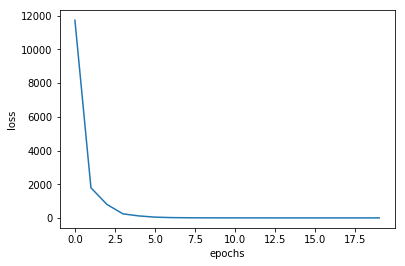

In [20]:
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')

In [21]:
model

In [22]:
def prediction_plot(X, model, idx):
    """
    Compute the Inferred shape binary mask using the trained stacked AE model
    :param X: dataset to predict
    :param model: trained AE model
    :param idx: index of the particular picture to return
    :return: inferred shape binary mask, infered shape on the MR image
    """
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    # thresholding
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64)

In [23]:
#n is number of test images
n = img_test.shape[0]
pred_mask,pred_img=[],[]
for i in range(n):
    bin_mask,img = prediction_plot(X_train,model,i)
    pred_mask.append(bin_mask)
    pred_img.append(img)
pred_mask = np.array(pred_mask)
pred_img = np.array(pred_img)
print (pred_mask.shape)

(279, 64, 64)


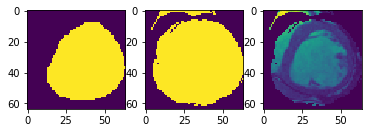

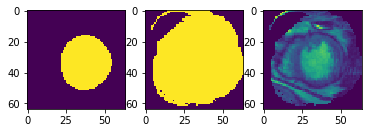

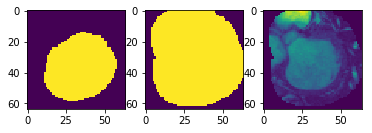

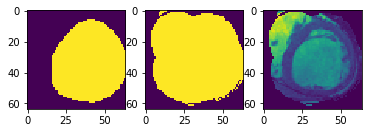

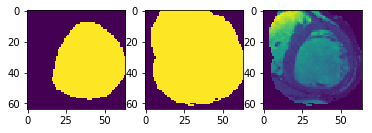

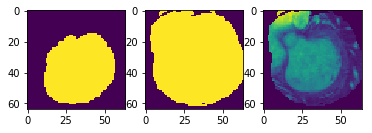

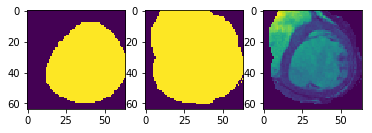

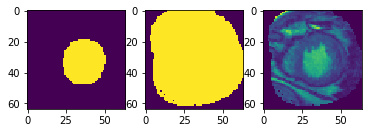

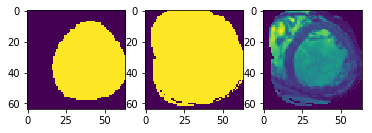

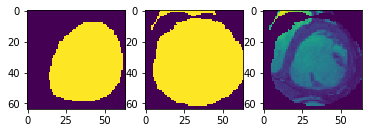

In [24]:
for i in range(10):
    plt.figure()
    plt.subplot(131)
    plt.imshow(Y_train[i].reshape((64,64)))
    plt.subplot(132)
    plt.imshow(pred_mask[i])
    plt.subplot(133)
    plt.imshow(pred_img[i])

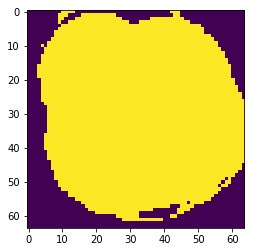

In [36]:
from skimage import measure
pred_mask.shape
img = pred_img[10]

pred_single = pred_mask[10]
contour = measure.find_contours(pred_single, 0.8)
plt.imshow(pred_single)

In [35]:
print(len(contour))
print(contour[0])
print(contour[1])
print(contour[2])

6
[[ 0.  13.2]
 [ 0.2 13. ]
 [ 0.2 12. ]
 [ 1.  11.2]
 [ 1.2 11. ]
 [ 2.  10.2]
 [ 2.2 10. ]
 [ 3.   9.2]
 [ 3.2  9. ]
 [ 3.   8.8]
 [ 2.   8.8]
 [ 1.   8.8]
 [ 0.8  9. ]
 [ 0.   9.8]]
[[44.2 63. ]
 [45.  62.2]
 [46.  62.2]
 [46.2 62. ]
 [47.  61.2]
 [47.2 61. ]
 [48.  60.2]
 [48.2 60. ]
 [49.  59.2]
 [50.  59.2]
 [50.2 59. ]
 [51.  58.2]
 [51.2 58. ]
 [51.2 57. ]
 [51.  56.8]
 [50.8 57. ]
 [50.  57.8]
 [49.8 58. ]
 [49.  58.8]
 [48.2 58. ]
 [49.  57.2]
 [49.2 57. ]
 [50.  56.2]
 [50.2 56. ]
 [51.  55.2]
 [51.8 56. ]
 [52.  56.2]
 [52.2 56. ]
 [53.  55.2]
 [53.2 55. ]
 [54.  54.2]
 [54.2 54. ]
 [55.  53.2]
 [55.2 53. ]
 [55.2 52. ]
 [56.  51.2]
 [56.2 51. ]
 [56.2 50. ]
 [56.2 49. ]
 [57.  48.2]
 [57.2 48. ]
 [58.  47.2]
 [58.2 47. ]
 [58.2 46. ]
 [59.  45.2]
 [59.2 45. ]
 [59.2 44. ]
 [59.  43.8]
 [58.  43.8]
 [57.8 44. ]
 [57.  44.8]
 [56.2 44. ]
 [56.2 43. ]
 [56.2 42. ]
 [57.  41.2]
 [57.2 41. ]
 [57.2 40. ]
 [57.2 39. ]
 [57.2 38. ]
 [57.2 37. ]
 [58.  36.2]
 [58.2 36. ]
 [58.2 35

In [27]:
#Metrics
def dice_metric(X, Y):
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

def conformity_coefficient(X, Y):
    return (3*dice_metric(X,Y)-2)/dice_metric(X,Y)

In [34]:
dm = np.zeros(n)
cc= np.zeros(n)
for i in range(n):
    Y_true = Y_train[i].reshape((64,64))
    dm[i] = dice_metric(pred_mask[i],Y_true)
    cc[i] = conformity_coefficient(pred_mask[i],Y_true)
#print(dm)

[0.1929107  0.55386351 0.78358531 0.41854637 0.68313393 0.29687082
 0.26533444 0.32945556 0.44096872 0.76763754 0.30410596 0.57206955
 0.06854716 0.06527652 0.73773266 0.48078267 0.47208402 0.25415871
 0.44991386 0.89695399 0.77796189 0.58897638 0.78907683 0.73653049
 0.05617284 0.34059098 0.82009404 0.7581156  0.78022192 0.67056277
 0.59433962 0.69717868 0.62052296 0.70790378 0.46912114 0.63111888
 0.73419773 0.75343284 0.78810122 0.7551305  0.45193017 0.79308289
 0.79215535 0.6873778  0.31968504 0.72213312 0.78937085 0.72609322
 0.0792663  0.6388309  0.60284153 0.55934252 0.63972034 0.59061012
 0.44593587 0.44762367 0.76291955 0.16409037 0.5559322  0.484375
 0.47649919 0.50502283 0.56810557 0.18409091 0.39010417 0.56842576
 0.42203219 0.52045297 0.45540608 0.49612403 0.63916176 0.45990099
 0.55517942 0.46544276 0.67549947 0.69957343 0.6402893  0.5394171
 0.28112231 0.52493075 0.4832978  0.65814295 0.06701506 0.46695402
 0.57979845 0.4256064  0.62432139 0.37585302 0.5893186  0.5395499

/home/jingxi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
